In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [5]:
car_images = glob.glob('./data/vehicles/*/*.png')
notcar_images = glob.glob('./data/non-vehicles/*/*.png')
cars = []
notcars = []
for img in car_images:
    cars.append(img)
for img in notcar_images:
        notcars.append(img)
        
color_space = 'RGB'
car_features = extract_features(cars,
                                cspace=color_space,
                                spatial_size=(32, 32),
                                hist_bins=32, 
                                hist_range=(0, 256))
notcar_features = extract_features(notcars,
                                   cspace=color_space,
                                   spatial_size=(32, 32),
                                   hist_bins=32,
                                   hist_range=(0, 256))

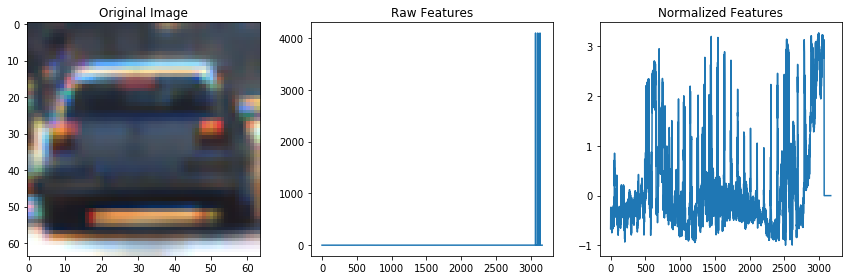

In [6]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [7]:
# check unbalance for major class problem
print(len(car_features))
print(len(notcar_features))

8792
8968


In [8]:
# concatenate features and labels
car_y, notcar_y = np.ones(len(car_features)), np.zeros(len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64) 
y = np.concatenate((car_y, notcar_y), axis=0)
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

shape of X:  (17760, 3168)
shape of y:  (17760,)


In [9]:
# split data into training data and test data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14208, 3168)
(3552, 3168)
(14208,)
(3552,)


In [10]:
# build a SVM model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
# predict test data and calcurate accuracy
predictions = clf.predict(X_test)
accuracy_score(predictions, y_test)

0.92032657657657657

In [12]:
# grid-search and cross-validation on linear SVM
#
# When `{'kernel': ['linear'], 'C': [1, 10, 50]}` on RGB images, 
# The best parameters was `{'C': 1, 'kernel': 'linear'}`.
tuned_parameters = [
    #{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}, 
    {'kernel': ['linear'], 'C': [0.1, 0.5, 1.0]}
]
clf = GridSearchCV(SVC(), tuned_parameters, cv=3, scoring='accuracy', n_jobs=4, verbose=1)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 11.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'C': [1, 10, 50], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [13]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}